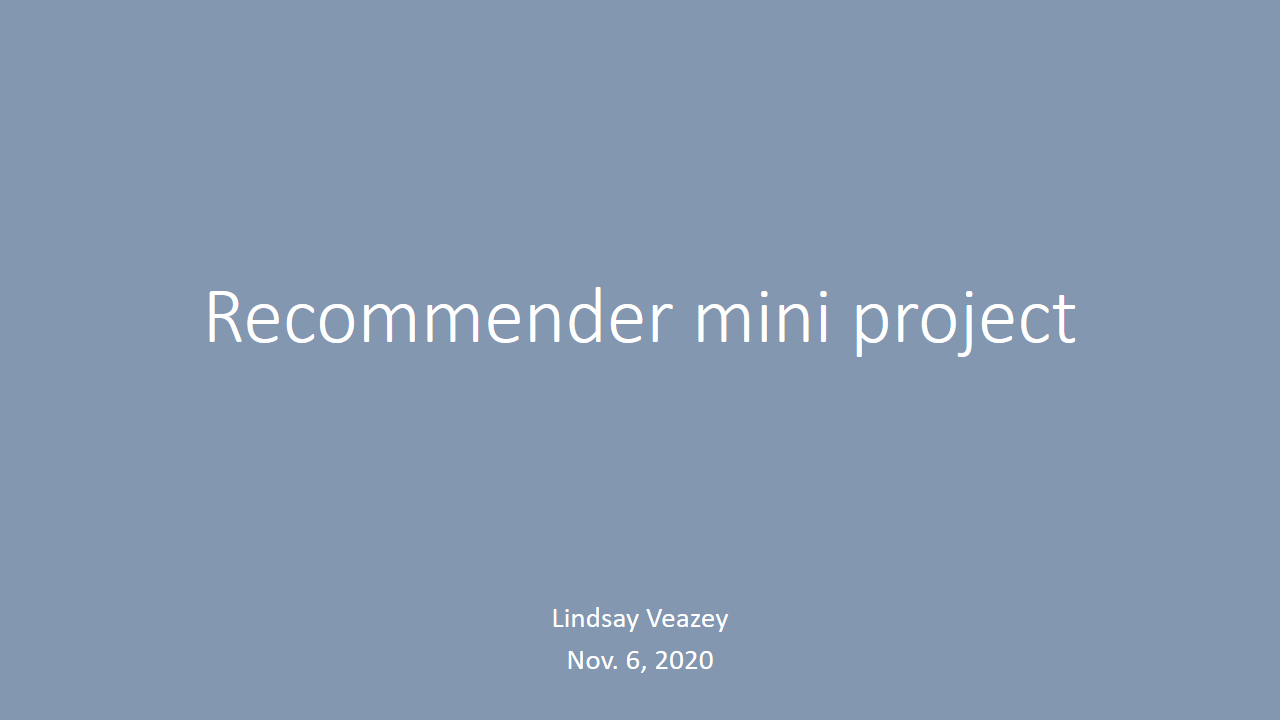

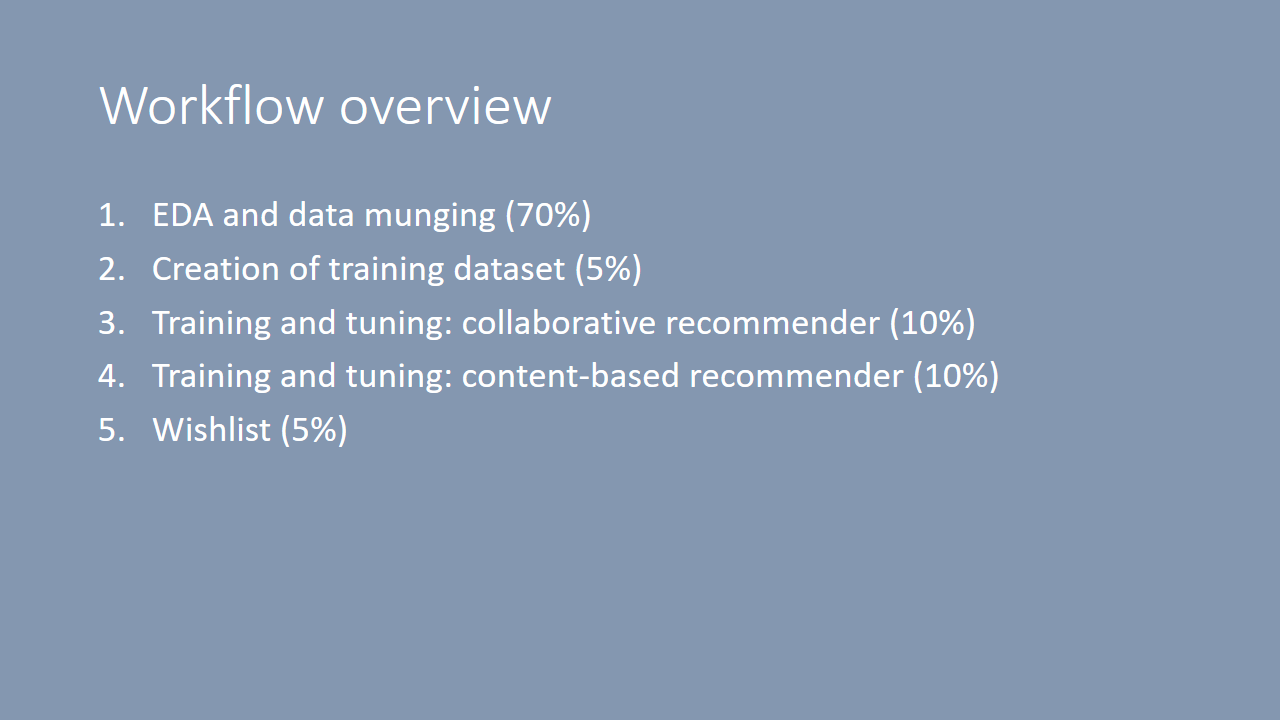

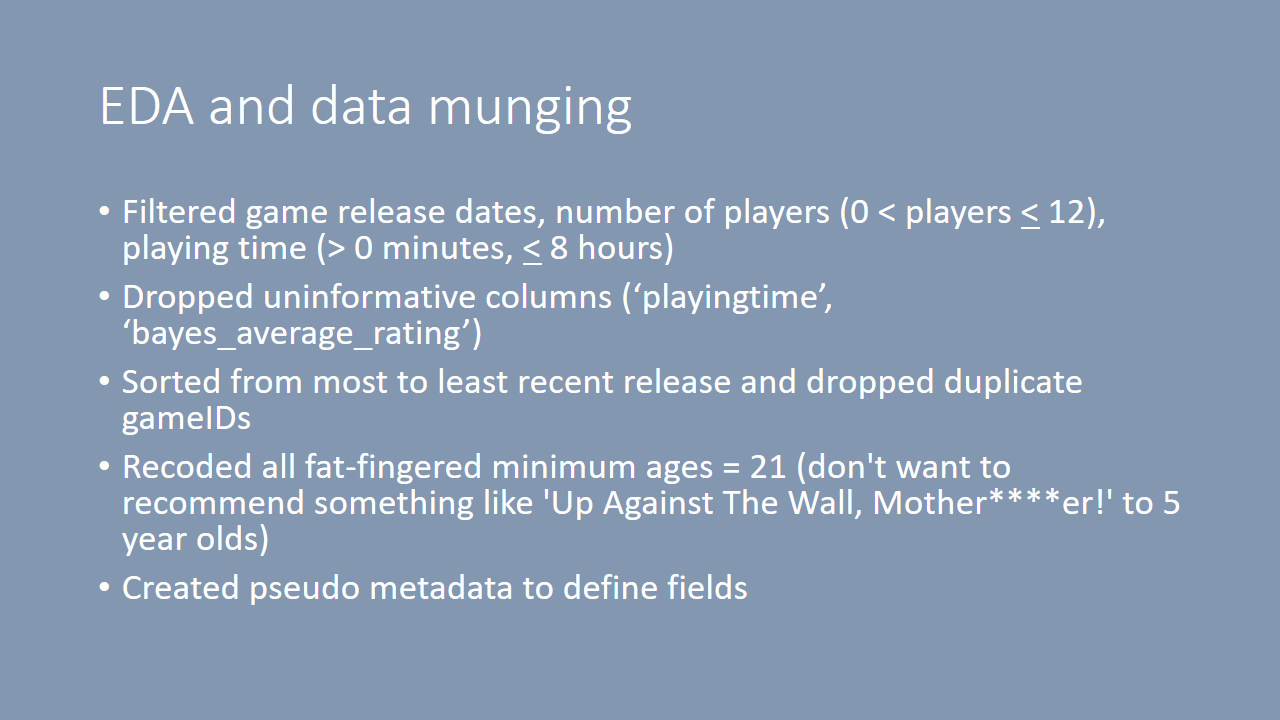

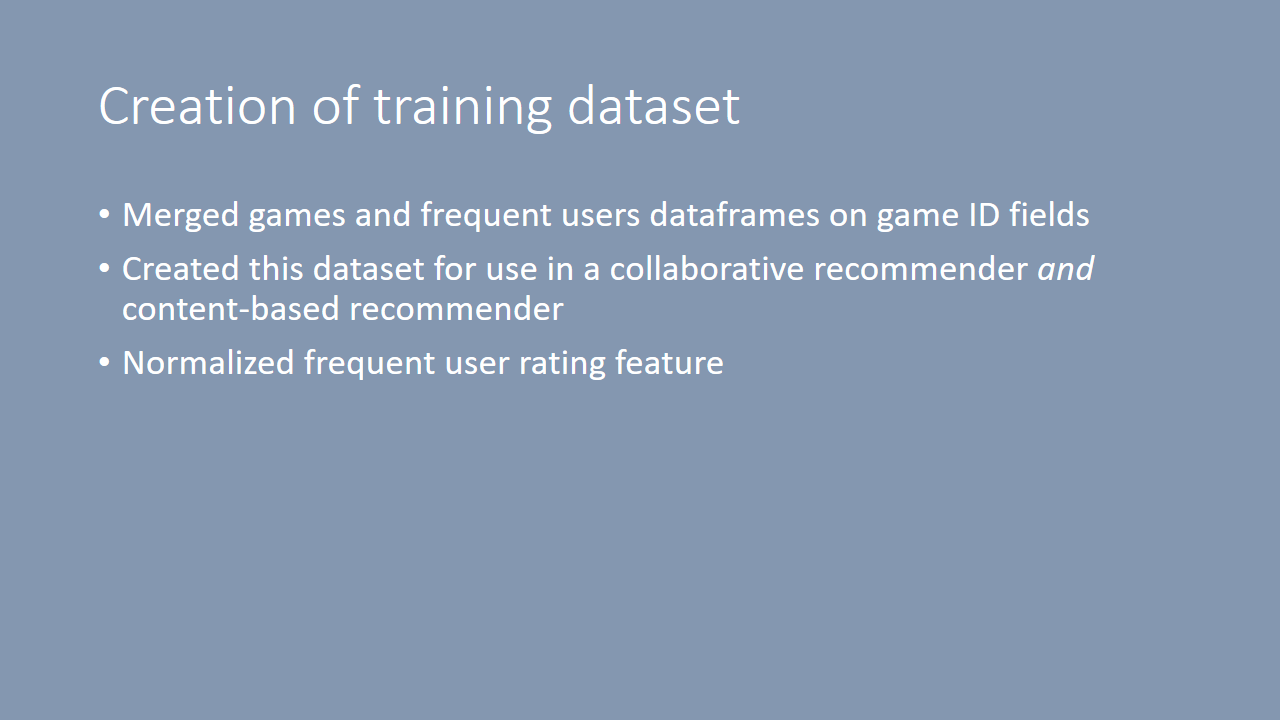

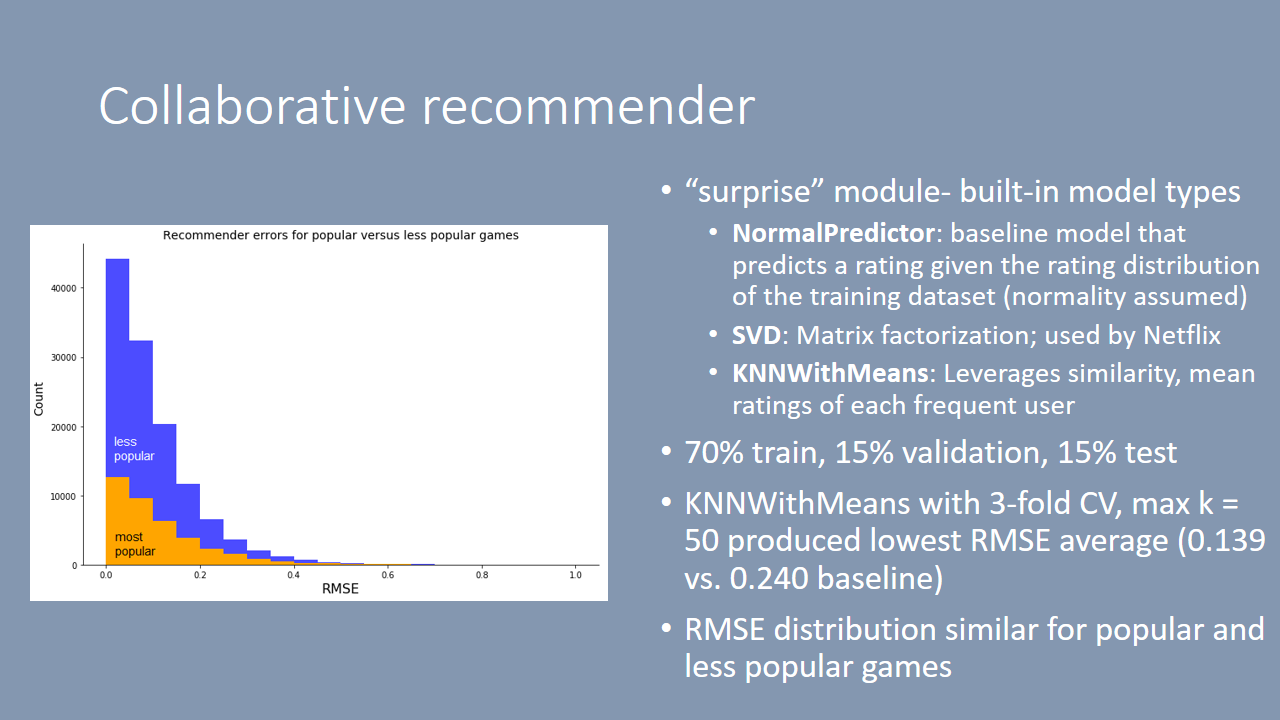

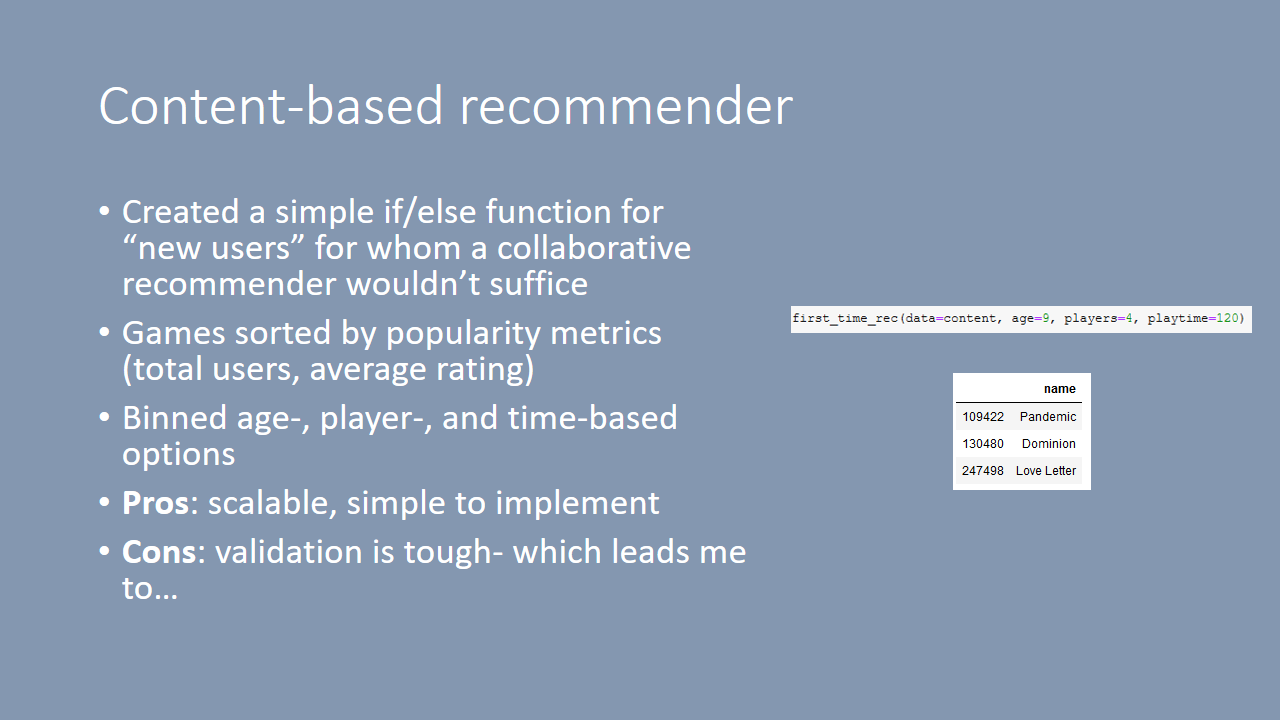

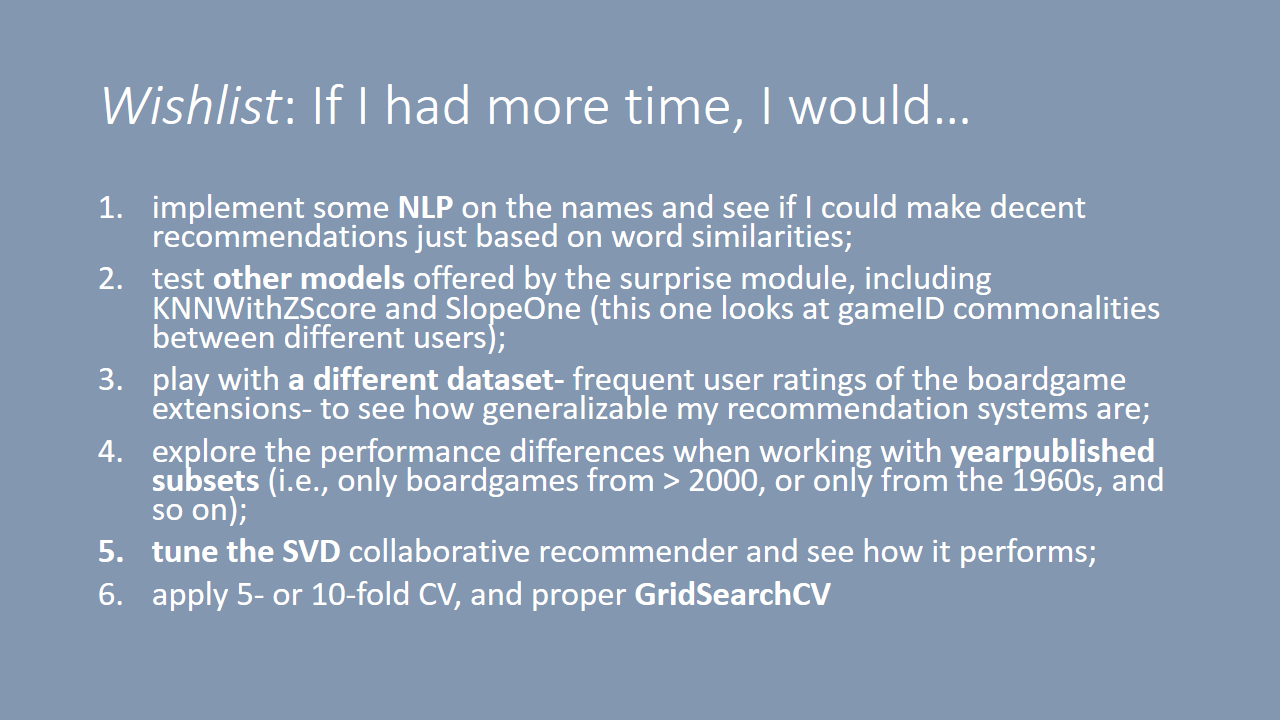

## Build a simple recommender system 

For this mini project, I'm tasked with building a recommendation system for boardgames. 

These files do *not* have metadata, and because this is just an exercise without references, I'm going to create my own "best guess metadata". Obviously, I wouldn't just guess the nature of these potential features for a productionalized project...

*References* (in no particular order): [1](https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html), [2](https://towardsdatascience.com/a-simple-approach-to-building-a-recommendation-system-d0f4de1a1f50), [3](http://www.solverworld.com/the-netflix-prize-singular-values-for-1-million/)

In [161]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns
from surprise import NormalPredictor, Reader, Dataset, accuracy, SVD, KNNWithMeans
from surprise.model_selection import cross_validate, KFold, GridSearchCV, train_test_split

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### Load files

In [2]:
users = pd.read_csv('boardgame-frequent-users.csv')
print(users.shape)
users.head(2)

(528872, 3)


,userID,gameID,rating
0,83,39938,7.0
1,83,34219,7.0


In [3]:
games = pd.read_csv('boardgames.csv')
print(games.shape)
games.head(2)

(81312, 20)


,id,type,name,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
0,12333,boardgame,Twilight Struggle,2005.0,2.0,2.0,180.0,180.0,180.0,13.0,20113,8.33774,8.22186,26647,372,1219,5865,5347,2562,3.4785
1,120677,boardgame,Terra Mystica,2012.0,2.0,5.0,150.0,60.0,150.0,12.0,14383,8.28798,8.14232,16519,132,1586,6277,2526,1423,3.8939


### Data exploration and munging

First, I'll restrict the games df "type" feature to boardgame only. 

I'm should be able to merge the users dataframe with the games dataframe based on the gameID and id fields.

In [4]:
games.type.value_counts()

boardgame             70820
boardgameexpansion    10492
Name: type, dtype: int64

Boardgame expansions are add-ons to existing games, and that means they are newer and less used than the boardgame upon which they're based. I'm dropping them from these data because I have to assume they are different enough that they might screw up my recommender- so, just sticking to base boardgame only here.

In [5]:
games=games[games['type'] == 'boardgame']
games.shape

(70820, 20)

In [6]:
users.gameID.describe()

count    528872.000000
mean      60760.634532
std       59830.485867
min           3.000000
25%        6472.000000
50%       36946.000000
75%      113924.000000
max      209010.000000
Name: gameID, dtype: float64

In [7]:
games.describe()

,id,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
count,70820.000000,70817.000000,70817.000000,70817.000000,70817.000000,70817.000000,70817.000000,70817.000000,70820.000000,70820.000000,70820.000000,70820.000000,70820.000000,70820.000000,70820.000000,70820.000000,70820.000000,70820.000000
mean,67163.862751,1785.782595,2.010125,5.549797,49.241750,46.736518,49.241750,6.724798,172.182957,3.931248,1.083140,251.516944,9.478354,12.425727,43.843886,52.341838,17.845947,0.835176
std,57282.842497,613.828659,0.873476,59.867724,362.165752,349.966512,362.165752,4.920125,1215.590155,2.991712,2.280649,1558.511540,41.950758,64.003963,253.818213,301.858146,123.458804,1.111839
min,1.000000,-3500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19476.750000,1981.000000,2.000000,2.000000,5.000000,9.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39541.500000,2002.000000,2.000000,4.000000,30.000000,30.000000,30.000000,8.000000,2.000000,5.000000,0.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,121068.250000,2009.000000,2.000000,6.000000,60.000000,60.000000,60.000000,10.000000,13.000000,6.406885,0.000000,34.000000,2.000000,2.000000,5.000000,7.000000,2.000000,1.647100
max,184451.000000,2018.000000,50.000000,11299.000000,60120.000000,60120.000000,60120.000000,99.000000,53680.000000,10.000000,8.221860,73188.000000,1395.000000,1586.000000,6402.000000,11798.000000,5996.000000,5.000000


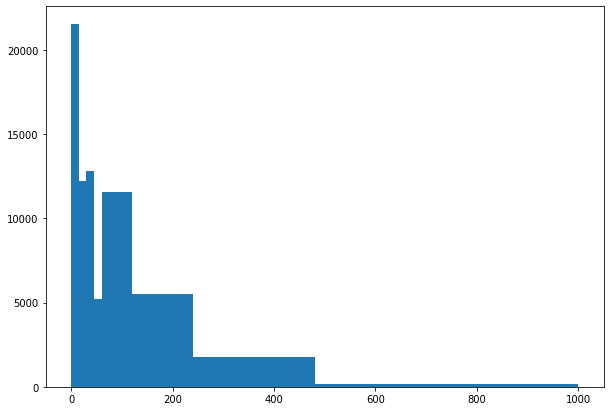

In [8]:
fig, ax = plt.subplots(figsize = (10, 7)) 
ax.hist(games.maxplaytime, bins = [0, 15, 30, 45, 60, 120, 240, 480, 1000]) # very few >> ~500
plt.show()

Further munging...

- Restricting games released in the past century- that seems reasonable!


- The number of players should be restricted to 1 - 12 people, in my opinion- particularly because the majority of maxplayers records = a half dozen.


- All games require at least 1 player with some non-zero playing time.


- Given that the majority of records for minplaytime and maxplaytime are >= 480, I'm assuming that these numbers correspond to minutes. After looking at maxplaytime further, I feel confident in delineating a cutoff for considered boardgames at 480.


- I see that 'playingtime' has the same statistics as 'maxplaytime'- dropping it and adding 'avgplaytime' column, in case I want to use that.


- I'm assuming that all minimum age records > 21 are fat fingered, and I'm remapping them all to = 21 (though this may be overly conservative- don't want to recommend something like 'Up Against The Wall, Mother****er!' to 5 year olds).

In [9]:
# Let's restrict all boardgames to a realistic timeframe
games = games[games['yearpublished'] >= 1920]
print(games.shape)

# All games require >0 players, >0 min time; assuming fields w/o this may be universally untrustworthy
# Only considering boardgames with <= a dozen players 
games = games[games['minplayers'] > 0]
games = games[games['maxplayers'] > 0]
games = games[games['minplayers'] <= 12]
games = games[games['maxplayers'] <= 12]
games = games[games['playingtime'] > 0]

print(games.shape)

(62224, 20)
(47081, 20)


In [10]:
games.drop(columns = 'playingtime', inplace = True)
# Restricting records to <= 8 hours play time
games = games[games['minplaytime'] <= 480]
games = games[games['maxplaytime'] <= 480]

# Creating an avgplaytime column based on the mean of minplaytime and maxplaytime- may use, may not
games['avgplaytime'] = games[['minplaytime', 'maxplaytime']].mean(axis=1)
games.shape

(46942, 20)

In [11]:
# All ages > 21 remapped to = 21
games['minage'] = np.where(games['minage'] > 21, 21, games['minage'] > 21)

In [12]:
print(games.id.nunique())
games.id.describe()

45190


count     46942.000000
mean      64359.998637
std       58416.805497
min           1.000000
25%       15011.250000
50%       36658.000000
75%      119986.750000
max      184451.000000
Name: id, dtype: float64

Dropping games.id duplicates by sorting from most to least recent year published so I can keep the most recent game edition rating:

In [13]:
games.sort_values(by = 'yearpublished', ascending = False, inplace = True)
print(games.yearpublished.head(3))

# Drop games.id duplicates
games.drop_duplicates(subset = 'id', keep = 'first', inplace = True)
print(games.shape)

64446    2017.0
62324    2017.0
64447    2017.0
Name: yearpublished, dtype: float64
(45190, 20)


In [14]:
# Take the mean rating of any userID and gameID duplicates
print(users.shape)
users = users.groupby(['userID', 'gameID']).mean()
print(users.shape) # No difference
users.reset_index(inplace = True)
users.head(3)

(528872, 3)
(528872, 1)


,userID,gameID,rating
0,83,5,7.0
1,83,12,8.0
2,83,13,8.0


I also think a collaborative recommender is the way to go because of the availability of the following fields in the games df (here is my pseudo metadata):

- **users_rated**: number of total unique ratings from players
- **average_rating**: mean rating 
- **minage**: minimum age 
- **users_rated**: total number of users that rated the game
- **average_rating** and **bayes_average_rating**: average ratings from users- but I'm dropping the bayes_average_rating column, as most values are 0! And it could be highly correlated with average_rating anyway.
- **total_owners** and **total_traders**: number of game purchases or trades
- **total_wanters** and **total_wishers**: not sure how wanting and wishing differ here, but their stats are different. For my pseudo metadata entry, I guress it's simply: number of people who have "wanted" and "wished for" the game (maybe public and private lists?) 
- **total_weights**: no idea- and I've tried (a cursory try, but still) to see a connection between this and average_weight. 
- **average_weight**: average of the mathematical combination of total_weights and some other metrics...

I think these metrics all look different enough that I can keep them for consideration if I decide to try a congent-based recommender- it doesn't seem as though even the more mysterious weights features are going to be problematically correlated.

In [15]:
games.drop(columns='bayes_average_rating', inplace = True)

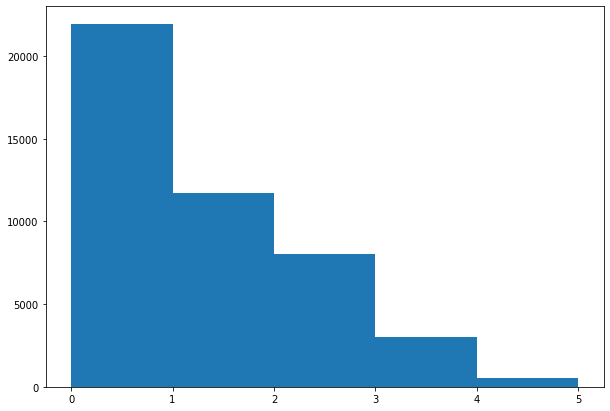

In [16]:
fig, ax = plt.subplots(figsize = (10, 7)) 
ax.hist(games.average_weight, bins = [0, 1, 2, 3, 4, 5]) 
plt.show()

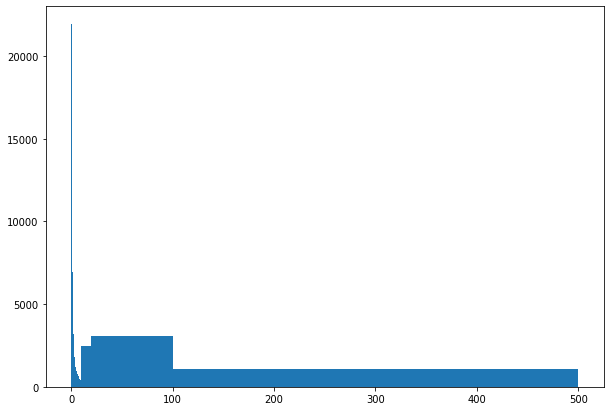

In [17]:
fig, ax = plt.subplots(figsize = (10, 7)) 
ax.hist(games.total_weights, bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 100, 500]) # and so on...
plt.show()

### Create training dataset

My initial thought is that I'll try a collaborative recommender because of the availability of game ratings from "frequent users"- using these data, I can train a system to recommend similar games to new or more infrequent players. 

To do this, I'll merge users and games dfs on their ID fields. I'm only interested in using the data that matches to the gameIDs rated by frequent users, because this restricts the data to boardgames only.

Collaborative recommenders are easier to build, but not as scalable in the event of sparse data, so that is a negative aspect of this approach if we planned to productionalize this.

In [18]:
both = pd.merge(users, games, left_on = 'gameID', right_on = 'id', how = 'outer', indicator = True)
both['_merge'].value_counts()

both          485606
right_only     44837
left_only      43266
Name: _merge, dtype: int64

In [19]:
# Extract data for frequent users
freq = both[both['_merge'] == 'both']
freq.head(3)

,userID,gameID,rating,id,type,name,yearpublished,minplayers,maxplayers,minplaytime,maxplaytime,minage,users_rated,average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight,avgplaytime,_merge
0,83.0,5.0,7.0,5.0,boardgame,Acquire,1962.0,3.0,6.0,90.0,90.0,0.0,13428.0,7.37367,16115.0,750.0,469.0,1912.0,4554.0,1488.0,2.5141,90.0,both
1,119.0,5.0,7.0,5.0,boardgame,Acquire,1962.0,3.0,6.0,90.0,90.0,0.0,13428.0,7.37367,16115.0,750.0,469.0,1912.0,4554.0,1488.0,2.5141,90.0,both
2,156.0,5.0,6.5,5.0,boardgame,Acquire,1962.0,3.0,6.0,90.0,90.0,0.0,13428.0,7.37367,16115.0,750.0,469.0,1912.0,4554.0,1488.0,2.5141,90.0,both


In [20]:
# Normalize rating feature
freq['norm_rating'] = (freq.rating - freq.rating.min()) / (freq.rating.max() - freq.rating.min())
freq.norm_rating.describe() # better

c:\users\linds\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


count    485606.000000
mean          0.654056
std           0.171451
min           0.000000
25%           0.555556
50%           0.666667
75%           0.777778
max           1.000000
Name: norm_rating, dtype: float64

In [23]:
# Using surprise to create a user ratings matrix- users are rows, gameIDs are columns
scale = (freq.norm_rating.min(), freq.norm_rating.max())
reader = Reader(rating_scale=scale)
surprise_df = Dataset.load_from_df(freq[['userID', 'gameID', 'norm_rating']], reader)

I'm going to use some built-in features of the suprise module to judge how to build the recommender:

1. **NormalPredictor**: baseline model that predicts a rating given the rating distribution of the training dataset (normality assumed)

2. **SVD**: Matrix factorization; used by Netflix.

3. **KNNWithMeans**: Uses MSD similarity and mean ratings of each frequent user to execute KNN. 


To evaluate model peformance, I'm looking at the RMSE of each predicted vs. actual rating. I've got some information about the average playing time and min/max players as well, and leveraging these metrics may be valuable in assessing how appropriate the recommendations are to a user (i.e., someone who likes lengthy group games wouldn't like a solitary, short game, probably...)

In [24]:
# Use a 70/30 train/test split
train, testing = train_test_split(surprise_df, test_size = 0.3, random_state = 123)

# And divide half the test data for validation (tuning) purposes
validate = testing[0:72840]
test = testing[72841:]

In [25]:
# Using 3 fold CV
kfold = KFold(n_splits = 3, random_state = 123)

# Baseline model
norm_rmse = [] 

for train, validate in kfold.split(surprise_df):
    norm = NormalPredictor()
    norm.fit(train)
    norm_pred = norm.test(validate)
    norm_rmse.append(accuracy.rmse(norm_pred))
    
print(sum(norm_rmse) / 3 ) # The more either SVD or KNNWithMeans beats this RMSE, the better

RMSE: 0.2400
RMSE: 0.2398
RMSE: 0.2404
0.24005544042525365


In [26]:
# SVD model
svd_rmse = [] 

for train, validate in kfold.split(surprise_df):
    svd = SVD()
    svd.fit(train)
    svd_pred = svd.test(validate)
    svd_rmse.append(accuracy.rmse(svd_pred))
    
print(sum(svd_rmse) / 3 )

RMSE: 0.1409
RMSE: 0.1398
RMSE: 0.1404
0.14036949259265705


In [31]:
# KNNWithMeans
knn_rmse = [] 

for train, validate in kfold.split(surprise_df):
    knn = KNNWithMeans(k = 20, min_k = 1) 
    knn.fit(train)
    knn_pred = knn.test(validate)
    knn_rmse.append(accuracy.rmse(knn_pred,verbose=False))

print(sum(knn_rmse) / 3 )

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
0.13873485114591297


### Hyperparameter tuning

KNN is slightly superior in its RMSE average, so I'm tuning it below.

GridSearchCV **does NOT** agree with my laptop's computational limitations! So I'm manually "tuning" based on a couple combinations of parameters of importance.

These are the parameter options I'm manually working with...

- 'k': 50 # max num of neighbors to take into account; default = 40
- 'min_k': 5, # min num of neighbors; default = 1 (or universal mean, if none)
- not able to test sim_options, but the cosine would be nice to try- just sticking w/MSD default

In [32]:
# k = 50, min_k = 1
knn_rmse = [] 
for train, validate in kfold.split(surprise_df):
    knn = KNNWithMeans(k = 50, min_k = 1) 
    knn.fit(train)
    knn_pred = knn.test(validate)
    knn_rmse.append(accuracy.rmse(knn_pred,verbose = False))

print(sum(knn_rmse) / 3 )

# k = 50, min_k = 5
knn_rmse = [] 
for train, validate in kfold.split(surprise_df):
    knn = KNNWithMeans(k = 50, min_k = 5) 
    knn.fit(train)
    knn_pred = knn.test(validate)
    knn_rmse.append(accuracy.rmse(knn_pred, verbose = False))

print(sum(knn_rmse) / 3 )

# k = 10, min_k = 5
knn_rmse = [] 
for train, validate in kfold.split(surprise_df):
    knn = KNNWithMeans(k = 10, min_k = 5) 
    knn.fit(train)
    knn_pred = knn.test(validate)
    knn_rmse.append(accuracy.rmse(knn_pred, verbose = False))

print(sum(knn_rmse) / 3 )

# This is really janky but it's doing the job...
# k = 50 is superior to k = 10- so minimally, but every bit counts

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
0.13813042907647932
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
0.13813042907647932
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
0.1399320986327815


Based on the RMSE above, I'm using this combination of parameters:

**k** = 50

**min_k** = 1

In [58]:
knn_rmse = [] 
for train, test in kfold.split(surprise_df):
    knn = KNNWithMeans(k = 50, min_k = 1) 
    knn.fit(train)
    final_pred = knn.test(test)
    final_rmse = accuracy.rmse(knn_pred, verbose = False)
    knn_rmse.append(final_rmse)

print(sum(knn_rmse) / 3 ) # pretty similar performance on the withheld test data

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
0.13988768574240018


In [71]:
results = pd.DataFrame(final_pred, columns = ['userID', 'gameID', 'norm_rating', 'model_est', 'details'])     
results['error'] = abs(results.model_est - results.norm_rating)

In [72]:
results = pd.merge(results, games, left_on = 'gameID', right_on = 'id', how = 'left', indicator = True)
results['_merge'].value_counts()

both          161868
right_only         0
left_only          0
Name: _merge, dtype: int64

In [75]:
results.total_owners.describe()

count    161868.000000
mean      13176.822479
std       11589.763381
min           1.000000
25%        6352.000000
50%        9660.000000
75%       15556.000000
max       73188.000000
Name: total_owners, dtype: float64

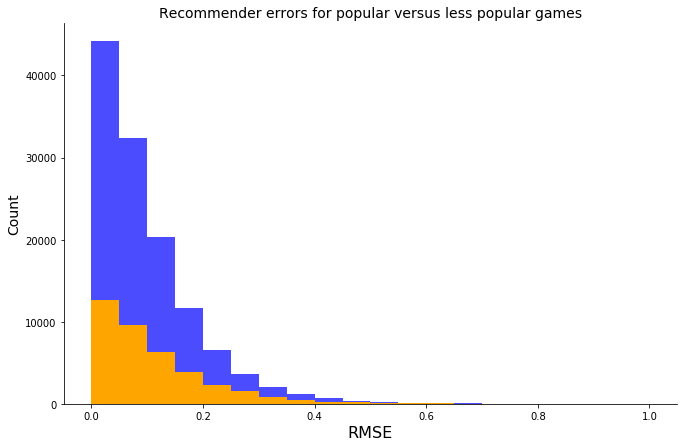

In [133]:
# Look at popularity versus error
popular = results[results.total_owners > 16000]
less_popular = results[results.total_owners <= 16000]
    
plt.figure(figsize=(11, 7))
plt.hist(less_popular.error, bins=20, color = 'blue', alpha=.7)
plt.hist(popular.error, bins=20, color = 'orange')
plt.xlabel('RMSE', size=16)
plt.ylabel('Count', size=14)
plt.title('Recommender errors for popular versus less popular games', size=14)
sns.despine();

# For more and less popular games, RMSE is nice and low

In [139]:
less_popular.error.describe()

count    123702.000000
mean          0.099707
std           0.091445
min           0.000000
25%           0.034079
50%           0.074343
75%           0.137590
max           1.000000
Name: error, dtype: float64

In [138]:
popular.error.describe()

count    38166.000000
mean         0.109030
std          0.098483
min          0.000000
25%          0.036812
50%          0.081731
75%          0.151764
max          1.000000
Name: error, dtype: float64

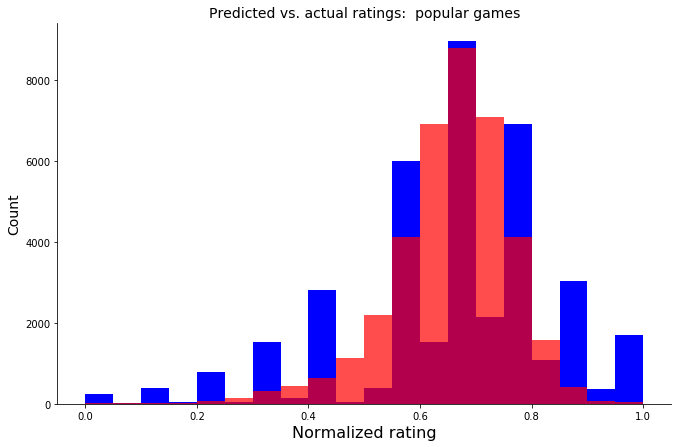

In [156]:
# Look at actual ratings versus predicted- popular games
actual = popular.norm_rating
predicted = popular.model_est
    
plt.figure(figsize=(11, 7))
plt.hist(actual, bins=20, color = 'blue')
plt.hist(predicted, bins=20, color = 'red', alpha = 0.7)
plt.xlabel('Normalized rating', size=16)
plt.ylabel('Count', size=14)
plt.title('Predicted vs. actual ratings:  popular games', size=14)
sns.despine();

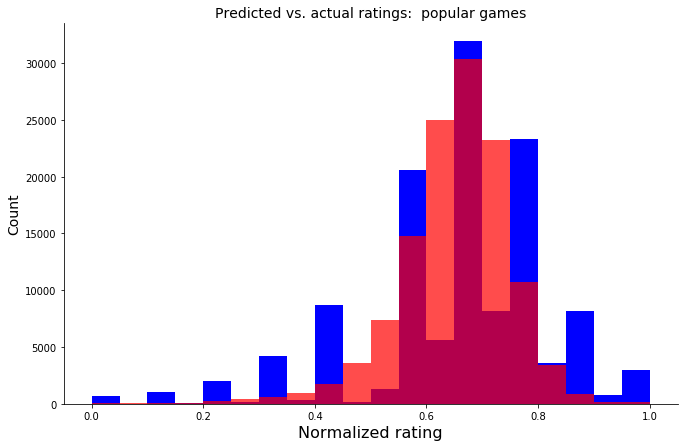

In [157]:
# Look at actual ratings versus predicted- popular games
actual = less_popular.norm_rating
predicted = less_popular.model_est
    
plt.figure(figsize=(11, 7))
plt.hist(actual, bins=20, color = 'blue')
plt.hist(predicted, bins=20, color = 'red', alpha = 0.7)
plt.xlabel('Normalized rating', size=16)
plt.ylabel('Count', size=14)
plt.title('Predicted vs. actual ratings:  popular games', size=14)
sns.despine();

# The model clearly assumes a bell curve for both popular and less popular games. 
# f anything it's more prone to under- vs. over-estimating

### First-time users: incorporate content-based features in recommendation

With the bit of time I have left, I'm going to make a recommender for first-timers.

What if you're a totally new user and have no way of getting a recommendation based on your game rating history?

Here, I'm using select features to make a recommendation to a first-timer based on their input preferences for desired number of players, maximum possible play time, and age. I'm sorting the dataframe by number of owners (preferentially, to select most popular games) and (secondarily) rating and selecting the top 3 records as recommendations.

In [40]:
content = freq[['userID', 'gameID', 'name', 'maxplayers', 'maxplaytime', 'minage', 'total_owners', 'average_rating']]
content.sort_values(by = ['total_owners', 'average_rating'], ascending = False, inplace = True)
content.describe()

,userID,gameID,maxplayers,maxplaytime,minage,total_owners,average_rating
count,485606.000000,485606.000000,485606.000000,485606.000000,485606.0,485606.000000,485606.000000
mean,96852.831979,60152.260683,5.001827,77.481059,0.0,13200.024545,7.326685
std,55722.449611,57912.394654,1.738952,55.780673,0.0,11599.796619,0.748915
min,83.000000,3.000000,1.000000,10.000000,0.0,1.000000,0.000000
25%,48483.750000,8217.000000,4.000000,30.000000,0.0,6457.000000,7.090190
50%,99134.000000,37046.000000,5.000000,60.000000,0.0,9789.000000,7.415400
75%,143684.000000,113294.000000,6.000000,90.000000,0.0,15556.000000,7.696910
max,193491.000000,183394.000000,12.000000,360.000000,0.0,73188.000000,9.000000


In [122]:
def first_time_rec(data, age, players, playtime):
    '''
    1. data: dataframe used to make predictions for first time users
    2. age: input age of user (years)
    3. players: max number of players
    4. playtime: max playtime preferred by user (minutes)
    '''
    # Filter df based on age
    if age <= 10: 
        data = data[data.minage <= 10]
    elif age > 10 & age < 21: 
        data = data[data.minage < 21]
    else:
        data = data[data.minage < 100]
        
    # Filter df based on players
    if players < 2: 
        data = data[data.maxplayers < 2]
    elif players > 2 & players <= 4: 
        data = data[(data.maxplayers > 2) & (data.maxplayers <= 4)]
    elif players > 4 & players <= 8: 
        data = data[(data.maxplayers > 4) & (data.maxplayers <= 8)]
    else:
        data = data[data.maxplayers > 8]
              
    # Filter df based on playtime
    if playtime <= 15: 
        data = data[data.maxplaytime <= 15]
    elif playtime > 15 & playtime <= 45: 
        data = data[(data.maxplaytime > 15) & (data.maxplaytime <= 45)]
    elif playtime > 45 & playtime <= 90: 
        data = data[(data.maxplaytime > 45) & (data.maxplaytime <= 90)]
    elif playtime > 90 & playtime <= 270: 
        data = data[(data.maxplaytime > 90) & (data.maxplaytime <= 270)]
    else:
        data = data[data.maxplaytime < 1000] # you must be in quarantine if you're playing boardgames for > 3 hours
        
    recs = data.head(3)
    recs.drop_duplicates(subset = 'name', inplace=True)
    return recs[['name']]

In [123]:
first_time_rec(data=content, age=9, players=4, playtime=120)

# Pretty good top recommendation there...

c:\users\linds\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,name
109422,Pandemic
130480,Dominion
247498,Love Letter


Problematically, validation is tough here! I already know that I am getting the most popular, highest rated top 3 recommendations this simpke if/else statement function, so it's doing it's job there- these games are popular with players of a similar age and with the same number of maximum players and free time. However...

### If I had more time, I would...

1. implement some NLP on the name of the games and see if I could make decent recommendations just based on word similarities.


2. test other models offered by the surprise module, including KNNWithZScore and SlopeOne (this one looks at gameID commonalities between different users).


3. play with a different dataset- frequent user ratings of the boardgame extensions- to see how generalizable it is.

4. explore the performance differences when working with yearpublished subsets (i.e., only boardgames from > 2000, or only from the 1960s, and so on).


5. tune the SVD collaborative recommender and see how it performs.


6. apply 5- or 10-fold CV, and GridSearchCV. My laptop can only handle so much, folks.